In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import qtl.norm as norm
import statsmodels.api as sm
from topmed_manuscript_clean import gtf_to_df, get_genotypes_from_vcf

def residualize(x, covariates):
    assert(isinstance(x, pd.Series) or isinstance(x, pd.DataFrame))
    assert(isinstance(covariates, pd.DataFrame))
    if isinstance(x, pd.Series):
        model = sm.OLS(x, sm.add_constant(covariates.T)).fit()
        return model.resid
    else:
        return x.transform(lambda y: residualize(y, covariates))


def plot_association(phenotype, covariates, variant, vcf, gene_name, gene_chrom, modality):
    samples = covariates.columns.to_list()
    assert(phenotype.index.to_list() == samples)
    variant_chrom, variant_pos, variant_ref, variant_alt = variant.split('_')

    genotypes = get_genotypes_from_vcf(vcf, variants=[variant], samples=samples).loc[variant,samples]
    p_residuals = residualize(phenotype, covariates)
    p_residuals = norm.inverse_normal_transform(p_residuals)

    df = pd.DataFrame({'phenotype': p_residuals, 'genotype': genotypes})
    df['alt_alleles'] = df.genotype.str.count('1')
    df['human_readable_genotype'] = df.genotype.str.replace('0', variant_ref).str.replace('1', variant_alt)

    fig, ax = plt.subplots(figsize=(3,2))

    sns.boxplot(x='human_readable_genotype', y='phenotype', data=df.sort_values('human_readable_genotype'), ax=ax, showfliers=False, color='white')
    sns.stripplot(x='human_readable_genotype', y='phenotype', data=df.sort_values('human_readable_genotype'), ax=ax, alpha=0.1, color='black')
    ax.set_xlabel(f'{variant} genotype')
    feature_type = 'expression\n' if 'eQTL' in modality else 'intron\nexclusion'
    ax.set_ylabel(f'{gene_name} {feature_type} ({gene_chrom})')
    ax.set_yticks([])

    return (fig, ax)


PREFIX = 'Fig1B.'
GTF = '../../manuscript-intermediate-processing/data/gtf/gencode.v30.GRCh38.ERCC.genes.collapsed_only.gtf.gz'
VCF_DIR = '../../manuscript-intermediate-processing/data/genotypes/vcfs-updated-ids-pass-filter' # must contain VCF files {chrom}.vcf.gz
TENSORQTL_IN_DIR = '../../manuscript-intermediate-processing/data/tensorqtl-in/joint'
EQTL_PHENOTYPES = os.path.join(TENSORQTL_IN_DIR, 'cis-eqtl/Whole_blood.tensorqtl-in.phenotypes.bed.gz')
SQTL_PHENOTYPES = os.path.join(TENSORQTL_IN_DIR, 'cis-sqtl/Whole_blood.tensorqtl-in.phenotypes.bed.gz')
CIS_EQTL_COVARIATES = os.path.join(TENSORQTL_IN_DIR, 'cis-eqtl/Whole_blood.tensorqtl-in.100.covariates.tsv')
CIS_SQTL_COVARIATES = os.path.join(TENSORQTL_IN_DIR, 'cis-sqtl/Whole_blood.tensorqtl-in.10.covariates.tsv')
TRANS_EQTL_COVARIATES = os.path.join(TENSORQTL_IN_DIR, 'trans-eqtl/Whole_blood.tensorqtl-in.100.covariates.tsv')
TRANS_SQTL_COVARIATES = os.path.join(TENSORQTL_IN_DIR, 'trans-sqtl/Whole_blood.tensorqtl-in.10.covariates.tsv')

In [2]:
gtf_df = gtf_to_df(GTF, parse_attributes=['gene_id', 'gene_name'])
gene_id_to_gene_name = dict(zip(gtf_df.gene_id, gtf_df.gene_name))
gene_id_to_chrom = dict(zip(gtf_df.gene_id, gtf_df.chrom))

In [3]:
eqtl_phenotypes = pd.read_csv(EQTL_PHENOTYPES, sep='\t', index_col=None).drop(columns=['#chr', 'start', 'end']).set_index('gene_id')
cis_eqtl_covariates = pd.read_csv(CIS_EQTL_COVARIATES, sep='\t', index_col=0)
trans_eqtl_covariates = pd.read_csv(TRANS_EQTL_COVARIATES, sep='\t', index_col=0)
sqtl_phenotypes = pd.read_csv(SQTL_PHENOTYPES, sep='\t', index_col=None).drop(columns=['#chr', 'start', 'end']).set_index('ID')
cis_sqtl_covariates = pd.read_csv(CIS_SQTL_COVARIATES, sep='\t', index_col=0)
trans_sqtl_covariates = pd.read_csv(TRANS_SQTL_COVARIATES, sep='\t', index_col=0)

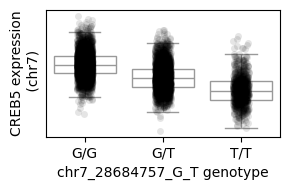

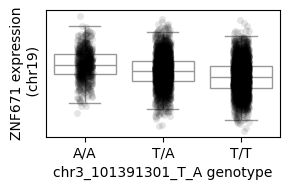

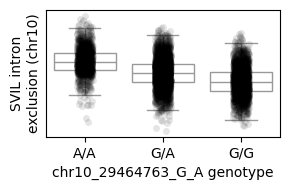

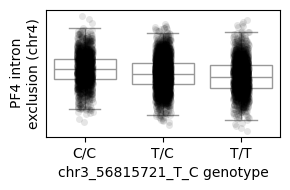

In [4]:
modalities = ['cis-eQTL', 'trans-eQTL', 'cis-sQTL', 'trans-sQTL']
variants = ['chr7_28684757_G_T', 'chr3_101391301_T_A', 'chr10_29464763_G_A', 'chr3_56815721_T_C']
phenotypes = ['ENSG00000146592.17', 'ENSG00000083814.13', 'chr10:29463635:29465595:clu_5546_-:ENSG00000197321.14', 'chr4:73981543:73981863:clu_33135_-:ENSG00000163737.3']
covariates_mapping = {
    'cis-eQTL': cis_eqtl_covariates,
    'trans-eQTL': trans_eqtl_covariates,
    'cis-sQTL': cis_sqtl_covariates,
    'trans-sQTL': trans_sqtl_covariates
}

for m, v, p in zip(modalities, variants, phenotypes):
    gene = p if re.match('^ENSG', p) else p.split(':')[-1]
    variant_chrom, variant_pos, variant_ref, variant_alt = v.split('_')
    vcf = os.path.join(VCF_DIR, f'{variant_chrom}.vcf.gz')
    phenotype = eqtl_phenotypes.loc[p] if 'eQTL' in m else sqtl_phenotypes.loc[p]
    covariates = covariates_mapping[m]

    fig, ax = plot_association(phenotype, covariates, v, vcf, gene_id_to_gene_name[gene], gene_id_to_chrom[gene], m)
    fig.tight_layout()
    fig.savefig('figures/{}{}.png'.format(PREFIX, m.lower().replace('-', '')), dpi=300, bbox_inches='tight')